# Results

## CUB200 InceptionV3_TF Features (SVM)


| Part Type | # parts | Global part only<br> <small>*Baseline*</small> | All parts | All parts<br> <small>*Local parts shuffled*</small> | Local parts only | Local parts only<br>  <small>*Local parts shuffled*</small>  |
|-|-|-|-|-|-|-|
|  GT Parts | 15 | 88.51 % | **89.82 %** | 86.68¹ % | 87.87 % | 82.69¹ % |
| GT2 Parts | 4  | 88.51 % | **90.18 %** | 87.68¹ % | 86.92 % | 80.20¹ % |
| NAC Parts | 20 | 88.51 % | **89.02 %** | 87.31¹ % | 87.92 % | 84.83¹ % |
| L1P Parts | 4  | 88.51 % | **89.45 %** | 89.23¹ % | 87.44 % | 87.33¹ % |
| L1F Parts | 4  | 88.51 % | **89.09 %** | 89.18¹ % | 86.99 % | 87.31¹ % |

¹ - needs more runs, since randomness involved

## CUB200 InceptionV3 Features (SVM)



*Small Reminder:* Baseline should be the same for all setups. Otherwise, something is wrong with the features!

| Part Type | # parts | Global part only<br> <small>*Baseline*</small> | All parts | All parts<br> <small>*Local parts shuffled*</small> | Local parts only | Local parts only<br>  <small>*Local parts shuffled*</small>  |
|-|-|-|-|-|-|-|
|  GT Parts | 15 | 88.47 % | **89.82 %** | 86.92¹ % | 87.95 % | 83.33¹ % |
| GT2 Parts | 4  | 88.47 % | **90.13 %** | 88.38¹ % | 86.80 % | 80.31¹ % |
| NAC Parts | 20 | 88.47 % | **89.09 %** | 87.49¹ % | 87.94 % | 85.12¹ % |
| L1P Parts | 4  | 88.47 % | **89.47 %** | 89.35¹ % | 87.45 % | 87.80¹ % |
| L1F Parts | 4  | 88.47 % | **89.13 %** | 88.80¹ % | 87.04 % | 87.19¹ % |

### LogRegression

| Part Type | # parts | Global part only<br> <small>*Baseline*</small> | All parts | All parts<br> <small>*Local parts shuffled*</small> | Local parts only | Local parts only<br>  <small>*Local parts shuffled*</small>  |
|-|-|-|-|-|-|-|
| GT Parts  | 15 | 87.81 % | **89.14 %** | xx.xx¹ % | 85.35 % | xx.xx¹ % |
| GT2 Parts | 4  | 87.81 % | **90.11 %** | xx.xx¹ % | 87.16 % | xx.xx¹ % |
| NAC Parts | 20 | 87.81 % | **88.33 %** | xx.xx¹ % | 86.83 % | xx.xx¹ % |
| L1P Parts | 4  | 87.81 % | **89.85 %** | xx.xx¹ % | 88.68 % | xx.xx¹ % |
| L1F Parts | 4  | 87.81 % | **89.97 %** | xx.xx¹ % | 88.71 % | xx.xx¹ % |

### LogisticRegression Baseline:
|Feature scale|C|Accuracy| |
|-|-|-|-|
| no | 0.01 | 87.81 % | |
| no | 0.1 | 89.42 % | (cannot reproduce anymore?)| 
| no | 1 | 89.11 % | (cannot reproduce anymore?)| 
| yes | 1 | 89.37 % | (cannot reproduce anymore?)| 
*cannot reproduce, since features are extracted with fine-tuned model*

## CARS InceptionV3 Features (SVM)



*Small Reminder:* Baseline should be the same for all setups. Otherwise, something is wrong with the features!

| Part Type | # parts | Global part only<br> <small>*Baseline*</small> | All parts | All parts<br> <small>*Local parts shuffled*</small> | Local parts only | Local parts only<br>  <small>*Local parts shuffled*</small>  |
|-|-|-|-|-|-|-|
| L1P Parts | 4  | 91.49 % | **92.45 %** | 92.35¹ % | 87.85 % | 88.04¹ % |
| L1F Parts | 4  | 91.49 % | **92.17 %** | 92.07¹ % | 87.97 % | 88.19¹ % |

### LogisticRegression Baseline:
|Feature scale|C|Accuracy|
|-|-|-|
| no | 0.01 | 91.47 % | 
| no | 0.1 | 91.49 % | 
| no | 1 | 91.49 % | 
| yes | 1 | 91.53 % | 

## Flowers InceptionV3 Features (SVM)



*Small Reminder:* Baseline should be the same for all setups. Otherwise, something is wrong with the features!

| Part Type | # parts | Global part only<br> <small>*Baseline*</small> | All parts | All parts<br> <small>*Local parts shuffled*</small> | Local parts only | Local parts only<br>  <small>*Local parts shuffled*</small>  |
|-|-|-|-|-|-|-|
| L1P Parts | 4  | 97.79 % | **96.93 %** | xx.xx¹ % | 94.02 % | xx.xx¹ % |
| L1F Parts | 4  | 97.79 % | **96.96 %** | xx.xx¹ % | 93.32 % | xx.xx¹ % |

### LogisticRegression Baseline:
|Feature scale|C|Accuracy|
|-|-|-|
| no | 0.01 | 97.63 % | 
| no | 0.1 | 97.69 % | 
| no | 1 | 97.69 % | 
| yes | 1 | 97.58 % | 

## iNAT19 InceptionV3 Features (SVM)



*Small Reminder:* Baseline should be the same for all setups. Otherwise, something is wrong with the features!

| Part Type | # parts | Global part only<br> <small>*Baseline*</small> | All parts | All parts<br> <small>*Local parts shuffled*</small> | Local parts only | Local parts only<br>  <small>*Local parts shuffled*</small>  |
|-|-|-|-|-|-|-|
| L1P Parts | 4  | 73.89 % | **76.30 %** | 75.64¹ % | 73.93 % | 73.23¹ % |
| L1F Parts | 4  | 73.89 % | **75.25 %** | 75.48¹ % | 73.50 % | 73.96¹ % |

### LogisticRegression Baseline:
|Feature scale|C|Accuracy|
|-|-|-|
| no | 0.01 | 72.01 % | 
| no | 0.1 | 72.54 % | 
| no | 1 | 72.84 % | 
| yes | 0.01 | 70.40 % | 
| yes | 0.1 | 71.65 % | 
| yes | 1 | 72.61 % | 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import joblib

from os.path import join
from matplotlib import pyplot as plt
from jupyter_utils.progress_bar import ProgressBar
from functools import partial

from nabirds.annotations import AnnotationType

from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

# Load data

In [3]:
BASE_DIR = "/home/korsch/Data"

# inception inception_tf resnet
FEATURE_MODEL = "inception"

# CUB200, CARS, INAT19
DATASET = "CARS"

# GLOBAL NAC GT GT2 L1_pred L1_full
PARTS = "L1_full"

KEY = "{}.{}.{}".format(DATASET, PARTS, FEATURE_MODEL)

DUMP = False

In [4]:
annot_cls = AnnotationType.get(DATASET).value
info = join(BASE_DIR, "info.yml")

print("Loading {} annotations from \"{}\"...".format(
    annot_cls, info))

annot = annot_cls(info, 
    parts="{}_{}".format(DATASET, PARTS),
    feature_model=FEATURE_MODEL
)

Loading <class 'nabirds.annotations.cars.CARS_Annotations'> annotations from "/home/korsch/Data/info.yml"...


In [5]:
train, val = [annot.new_dataset(subset) for subset in ["train", "test"]]

print("Loaded {} train and {} test images".format(len(train), len(val)))

train_feats = train.features
val_feats = val.features

print("Feature shapes: {} / {}".format(train_feats.shape, val_feats.shape))

assert train_feats is not None
assert val_feats is not None

Loaded 8144 train and 8041 test images
Feature shapes: (8144, 5, 2048) / (8041, 5, 2048)


In [6]:
def evaluate(X, y, X_val, y_val, clf_class=LinearSVC, scale=False):
    print(X.shape, X_val.shape)
    print(y, y_val)
    
    if scale:
        print("Scaling Data...")
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        X_val = scaler.transform(X_val)
    clf = clf_class()
    
    #print(cross_val_score(clf, X, y, cv=3, n_jobs=3))
    
    print("Training {0.__class__.__name__} Classifier...".format(clf))
    %time clf.fit(X, y)
    return clf, clf.score(X_val, y_val)

# Some Feature Stats

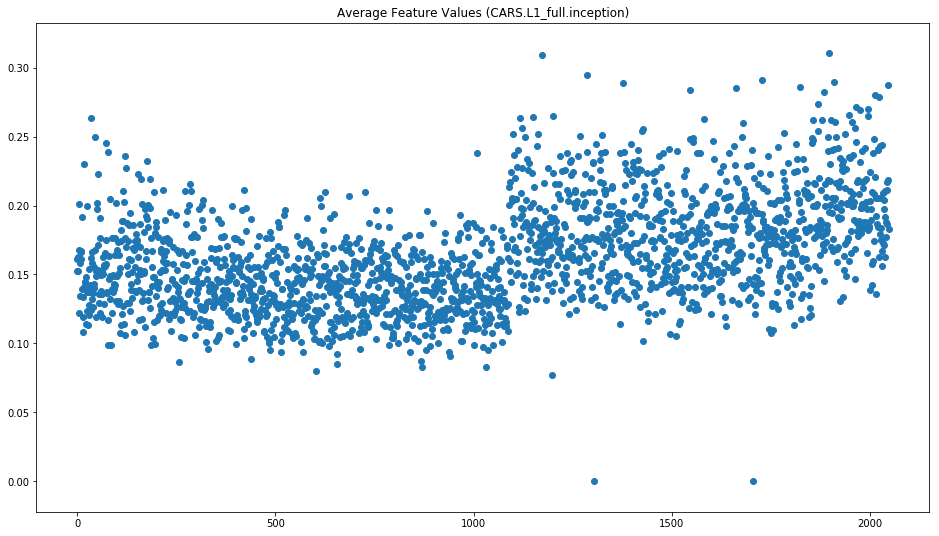

In [7]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(range(train_feats.shape[-1]), train_feats.mean(axis=(0,1)))
ax.set_title("Average Feature Values ({})".format(KEY))
plt.show()

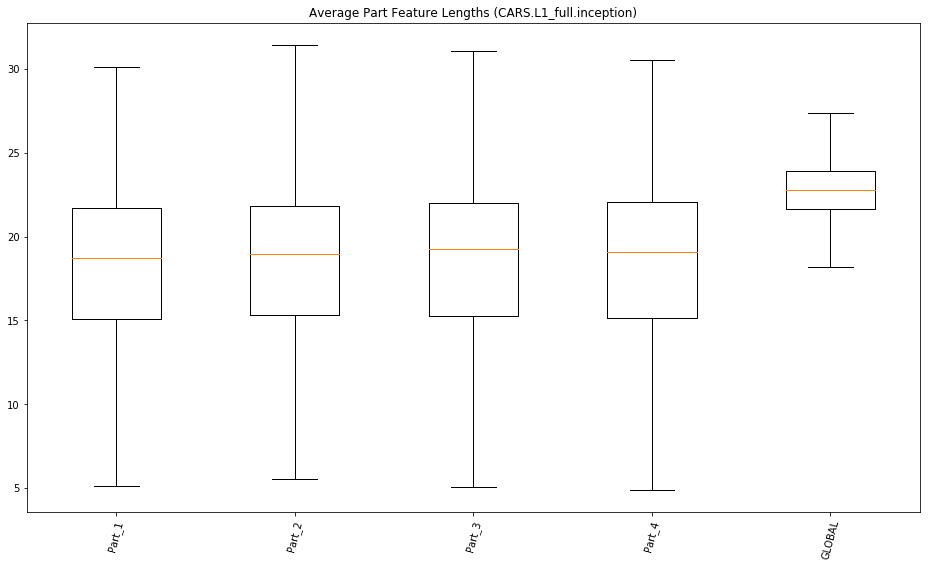

In [8]:
import matplotlib.pyplot as plt

feature_norms = np.sqrt(np.sum(train_feats ** 2, axis=-1))
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("Average Part Feature Lengths ({})".format(KEY))
ax.boxplot(feature_norms, showfliers=False)

if hasattr(train._annot, "part_name_list"):
    part_names = list(train._annot.part_name_list)
    if PARTS == "NAC":
        part_names *= 2
    part_names.append("GLOBAL")

    ax.set_xticklabels(part_names, rotation=75)
plt.show()

# Train SVM with sparse feature coefficients

# Train LogRegressor classifier on global part only

In [10]:
X, y = train_feats[:, -1, :], train.labels
X_val, y_val = val_feats[:, -1, :], val.labels

clf_class = partial(LogisticRegression, 
                    C=0.1,
                    solver='lbfgs', 
                    multi_class='multinomial', 
                    max_iter=500)

clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=True)
print("{:.2%}".format(score))

(8144, 2048) (8041, 2048)
[ 13   2  90 ... 162 111  16] [180 102 144 ...  16  37  31]
Scaling Data...
Training LogisticRegression Classifier...
CPU times: user 40.6 s, sys: 1.6 s, total: 42.2 s
Wall time: 10.8 s
91.49%


In [10]:
raise StopIteration

StopIteration: 

# Train SVM on global part only

In [11]:
X, y = train_feats[:, -1, :], train.labels
X_val, y_val = val_feats[:, -1, :], val.labels

clf, score = evaluate(X, y, X_val, y_val, scale=True)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_glob_only.npz".format(KEY))

(8144, 2048) (8041, 2048)
[ 13   2  90 ... 162 111  16] [180 102 144 ...  16  37  31]
Scaling Data...
Training LinearSVC Classifier...
CPU times: user 1min 3s, sys: 75.6 ms, total: 1min 3s
Wall time: 1min 3s
91.49%


# Train SVM on all parts

In [12]:
X, y = train_feats.reshape(len(train), -1), train.labels
X_val, y_val = val_feats.reshape(len(val), -1), val.labels

# clf_class = partial(LogisticRegression, 
#                     C=1,
#                     solver='lbfgs', 
#                     multi_class='multinomial',
#                     max_iter=300)
clf_class = LinearSVC
clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=True)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_all_parts.npz".format(KEY))

(8144, 10240) (8041, 10240)
[ 13   2  90 ... 162 111  16] [180 102 144 ...  16  37  31]
Scaling Data...
Training LinearSVC Classifier...


/home/korsch/.anaconda3/envs/chainer4/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CPU times: user 5min 20s, sys: 680 ms, total: 5min 20s
Wall time: 5min 20s
92.26%


# Train SVM on local parts only

In [13]:
X, y = train_feats[:, :-1, :].reshape(len(train), -1), train.labels
X_val, y_val = val_feats[:, :-1, :].reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=True)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_local_parts.npz".format(KEY))

(8144, 8192) (8041, 8192)
[ 13   2  90 ... 162 111  16] [180 102 144 ...  16  37  31]
Scaling Data...
Training LinearSVC Classifier...


/home/korsch/.anaconda3/envs/chainer4/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CPU times: user 3min 28s, sys: 340 ms, total: 3min 28s
Wall time: 3min 28s
88.19%


# Shuffle Part Positions

Shuffle parts for each sample. Leave global feature on the correct place.

In [14]:
train_feats_rnd = train_feats.copy()
val_feats_rnd = val_feats.copy()

bar = ProgressBar()

[np.random.shuffle(f[:-1]) for f in bar(train_feats_rnd)]
[np.random.shuffle(f[:-1]) for f in bar(val_feats_rnd)]

print("shuffling ready")

shuffling ready


# Train SVM on all parts

In [15]:
X, y = train_feats_rnd.reshape(len(train), -1), train.labels
X_val, y_val = val_feats_rnd.reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=True)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_all_parts_shuffled.npz".format(KEY))

(8144, 10240) (8041, 10240)
[ 13   2  90 ... 162 111  16] [180 102 144 ...  16  37  31]
Scaling Data...
Training LinearSVC Classifier...
CPU times: user 3min 35s, sys: 336 ms, total: 3min 35s
Wall time: 3min 35s
92.18%


# Train SVM on local parts only

In [16]:
X, y = train_feats_rnd[:, :-1, :].reshape(len(train), -1), train.labels
X_val, y_val = val_feats_rnd[:, :-1, :].reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val, clf_class, scale=True)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_local_parts_shuffled.npz".format(KEY))

(8144, 8192) (8041, 8192)
[ 13   2  90 ... 162 111  16] [180 102 144 ...  16  37  31]
Scaling Data...
Training LinearSVC Classifier...
CPU times: user 2min 52s, sys: 548 ms, total: 2min 52s
Wall time: 2min 52s
88.40%


# Old Cells